In [10]:
import tensorflow
import pickle

# Load pickle

In [62]:
data=pickle.load(open('positive-hometreat.pkl','rb'))
X = data.astype('float32')
X = (X - 127.5) / 127.5 
dataset=X

In [63]:
data.shape

(707, 128, 128, 3)

In [11]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Reshape,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,Dropout
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam

# Discriminator

In [65]:
def define_discriminator(in_shape=(128,128,3)):
    model = Sequential()

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
    model.add(LeakyReLU(alpha=0.2))
    

    model.add(Flatten()) #shape of 8192
    model.add(Dense(800,activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid')) #shape of 1
# compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model




In [66]:
d = define_discriminator()
print(d.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 8, 8, 128)       

# Generator

In [67]:
def define_generator(latent_dim):   
    model = Sequential()
    
    n_nodes = 128 * 8 * 8  
    model.add(Dense(n_nodes, input_dim=latent_dim)) 
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Reshape((8, 8, 128)))   
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
    200
    return model  


In [68]:
g = define_generator(100)
print(g.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 8192)              827392    
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                           

# GAN

In [30]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
   
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [31]:
de=define_gan(g,d)
de.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 128, 128, 3)       1901059   
                                                                 
 sequential_6 (Sequential)   (None, 1)                 7001537   
                                                                 
Total params: 8,902,596
Trainable params: 1,901,059
Non-trainable params: 7,001,537
_________________________________________________________________


# Generate real samples

In [32]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

# Generate Latent points

In [7]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Generate Fake Samples

In [34]:
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = zeros((n_samples, 1))  
    return X, y

In [35]:
#generator=define_generator(100)
#generate_fake_samples(generator,100,10)

# Train using GAN, Generator and Discriminator

In [69]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=16):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)   
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 

            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            
            X_gan = generate_latent_points(latent_dim, n_batch)
             
            y_gan = ones((n_batch, 1))
            
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
    g_model.save('ganforpos100.h5')

In [71]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
train(generator, discriminator, gan_model,dataset , latent_dim, n_epochs=100)

Epoch>1, Batch 1/44, d1=0.325, d2=1.332 g=0.323
Epoch>1, Batch 2/44, d1=0.212, d2=1.279 g=0.345
Epoch>1, Batch 3/44, d1=0.092, d2=1.212 g=0.376
Epoch>1, Batch 4/44, d1=0.014, d2=1.137 g=0.415
Epoch>1, Batch 5/44, d1=0.008, d2=1.065 g=0.461
Epoch>1, Batch 6/44, d1=0.002, d2=0.988 g=0.519
Epoch>1, Batch 7/44, d1=0.003, d2=0.885 g=0.617
Epoch>1, Batch 8/44, d1=0.036, d2=0.780 g=0.690
Epoch>1, Batch 9/44, d1=0.001, d2=0.721 g=0.872
Epoch>1, Batch 10/44, d1=0.013, d2=0.531 g=1.105
Epoch>1, Batch 11/44, d1=0.013, d2=0.397 g=1.394
Epoch>1, Batch 12/44, d1=0.000, d2=0.262 g=1.859
Epoch>1, Batch 13/44, d1=0.000, d2=0.149 g=2.444
Epoch>1, Batch 14/44, d1=0.000, d2=0.080 g=3.052
Epoch>1, Batch 15/44, d1=0.000, d2=0.048 g=3.536
Epoch>1, Batch 16/44, d1=0.000, d2=0.045 g=3.836
Epoch>1, Batch 17/44, d1=0.000, d2=0.064 g=5.059
Epoch>1, Batch 18/44, d1=0.000, d2=0.004 g=6.910
Epoch>1, Batch 19/44, d1=0.000, d2=0.001 g=7.166
Epoch>1, Batch 20/44, d1=0.000, d2=0.002 g=6.672
Epoch>1, Batch 21/44, d1=0.00

Epoch>4, Batch 37/44, d1=0.165, d2=0.134 g=2.428
Epoch>4, Batch 38/44, d1=0.096, d2=0.112 g=2.858
Epoch>4, Batch 39/44, d1=0.391, d2=0.218 g=2.204
Epoch>4, Batch 40/44, d1=0.321, d2=0.206 g=2.082
Epoch>4, Batch 41/44, d1=0.202, d2=0.406 g=2.377
Epoch>4, Batch 42/44, d1=0.390, d2=0.175 g=2.779
Epoch>4, Batch 43/44, d1=1.119, d2=0.509 g=1.936
Epoch>4, Batch 44/44, d1=0.290, d2=0.287 g=2.354
Epoch>5, Batch 1/44, d1=0.136, d2=0.156 g=2.532
Epoch>5, Batch 2/44, d1=0.390, d2=0.186 g=1.959
Epoch>5, Batch 3/44, d1=0.244, d2=0.203 g=2.222
Epoch>5, Batch 4/44, d1=1.099, d2=0.579 g=1.804
Epoch>5, Batch 5/44, d1=0.361, d2=0.359 g=1.930
Epoch>5, Batch 6/44, d1=0.500, d2=0.285 g=2.209
Epoch>5, Batch 7/44, d1=0.636, d2=0.472 g=2.292
Epoch>5, Batch 8/44, d1=0.319, d2=0.212 g=2.235
Epoch>5, Batch 9/44, d1=0.500, d2=0.446 g=1.586
Epoch>5, Batch 10/44, d1=0.354, d2=0.421 g=2.062
Epoch>5, Batch 11/44, d1=0.216, d2=0.127 g=2.361
Epoch>5, Batch 12/44, d1=0.316, d2=0.232 g=2.064
Epoch>5, Batch 13/44, d1=0.37

Epoch>8, Batch 29/44, d1=0.571, d2=0.258 g=1.467
Epoch>8, Batch 30/44, d1=0.116, d2=0.211 g=1.898
Epoch>8, Batch 31/44, d1=0.184, d2=0.314 g=2.182
Epoch>8, Batch 32/44, d1=0.211, d2=0.121 g=2.740
Epoch>8, Batch 33/44, d1=0.150, d2=0.096 g=2.529
Epoch>8, Batch 34/44, d1=0.119, d2=0.131 g=3.018
Epoch>8, Batch 35/44, d1=0.026, d2=0.069 g=3.259
Epoch>8, Batch 36/44, d1=0.123, d2=0.067 g=3.418
Epoch>8, Batch 37/44, d1=0.058, d2=0.111 g=3.242
Epoch>8, Batch 38/44, d1=0.065, d2=0.122 g=3.388
Epoch>8, Batch 39/44, d1=0.183, d2=0.169 g=2.976
Epoch>8, Batch 40/44, d1=0.262, d2=0.276 g=2.544
Epoch>8, Batch 41/44, d1=0.072, d2=0.151 g=2.968
Epoch>8, Batch 42/44, d1=0.120, d2=0.102 g=2.806
Epoch>8, Batch 43/44, d1=0.252, d2=0.277 g=2.402
Epoch>8, Batch 44/44, d1=0.455, d2=0.374 g=2.273
Epoch>9, Batch 1/44, d1=0.274, d2=0.313 g=2.431
Epoch>9, Batch 2/44, d1=0.343, d2=0.240 g=1.877
Epoch>9, Batch 3/44, d1=0.342, d2=0.431 g=2.166
Epoch>9, Batch 4/44, d1=0.364, d2=0.208 g=2.468
Epoch>9, Batch 5/44, d1=

Epoch>12, Batch 19/44, d1=0.149, d2=0.153 g=2.605
Epoch>12, Batch 20/44, d1=0.093, d2=0.098 g=3.370
Epoch>12, Batch 21/44, d1=0.055, d2=0.142 g=4.126
Epoch>12, Batch 22/44, d1=0.541, d2=0.441 g=3.072
Epoch>12, Batch 23/44, d1=0.148, d2=0.089 g=3.189
Epoch>12, Batch 24/44, d1=0.043, d2=0.094 g=3.191
Epoch>12, Batch 25/44, d1=0.045, d2=0.106 g=2.967
Epoch>12, Batch 26/44, d1=0.089, d2=0.341 g=3.764
Epoch>12, Batch 27/44, d1=0.240, d2=0.074 g=3.371
Epoch>12, Batch 28/44, d1=0.529, d2=0.539 g=3.823
Epoch>12, Batch 29/44, d1=0.294, d2=0.088 g=2.893
Epoch>12, Batch 30/44, d1=0.296, d2=0.508 g=3.493
Epoch>12, Batch 31/44, d1=0.590, d2=0.078 g=2.659
Epoch>12, Batch 32/44, d1=0.134, d2=0.282 g=2.871
Epoch>12, Batch 33/44, d1=0.153, d2=0.086 g=3.524
Epoch>12, Batch 34/44, d1=0.695, d2=0.251 g=2.438
Epoch>12, Batch 35/44, d1=0.196, d2=0.170 g=2.244
Epoch>12, Batch 36/44, d1=0.121, d2=0.265 g=3.374
Epoch>12, Batch 37/44, d1=0.195, d2=0.063 g=3.178
Epoch>12, Batch 38/44, d1=0.619, d2=0.133 g=2.533


Epoch>16, Batch 8/44, d1=0.134, d2=0.083 g=4.502
Epoch>16, Batch 9/44, d1=0.581, d2=0.218 g=2.510
Epoch>16, Batch 10/44, d1=0.319, d2=0.339 g=2.966
Epoch>16, Batch 11/44, d1=0.514, d2=0.395 g=3.154
Epoch>16, Batch 12/44, d1=0.112, d2=0.253 g=3.724
Epoch>16, Batch 13/44, d1=0.180, d2=0.275 g=3.430
Epoch>16, Batch 14/44, d1=0.633, d2=0.188 g=2.459
Epoch>16, Batch 15/44, d1=0.053, d2=0.288 g=2.960
Epoch>16, Batch 16/44, d1=0.136, d2=0.129 g=3.412
Epoch>16, Batch 17/44, d1=0.244, d2=0.353 g=3.229
Epoch>16, Batch 18/44, d1=0.103, d2=0.109 g=2.965
Epoch>16, Batch 19/44, d1=0.398, d2=0.246 g=3.152
Epoch>16, Batch 20/44, d1=0.364, d2=0.173 g=2.792
Epoch>16, Batch 21/44, d1=0.411, d2=0.234 g=2.868
Epoch>16, Batch 22/44, d1=0.034, d2=0.148 g=3.426
Epoch>16, Batch 23/44, d1=0.183, d2=0.296 g=4.063
Epoch>16, Batch 24/44, d1=0.196, d2=0.317 g=4.063
Epoch>16, Batch 25/44, d1=0.696, d2=0.052 g=2.122
Epoch>16, Batch 26/44, d1=0.144, d2=0.234 g=3.189
Epoch>16, Batch 27/44, d1=0.909, d2=0.672 g=2.886
Ep

Epoch>19, Batch 41/44, d1=0.300, d2=0.056 g=2.729
Epoch>19, Batch 42/44, d1=0.092, d2=0.204 g=2.148
Epoch>19, Batch 43/44, d1=0.502, d2=0.312 g=2.589
Epoch>19, Batch 44/44, d1=0.145, d2=0.256 g=2.471
Epoch>20, Batch 1/44, d1=0.158, d2=0.108 g=2.949
Epoch>20, Batch 2/44, d1=0.854, d2=0.370 g=2.070
Epoch>20, Batch 3/44, d1=0.234, d2=0.346 g=2.804
Epoch>20, Batch 4/44, d1=0.266, d2=0.251 g=2.759
Epoch>20, Batch 5/44, d1=0.214, d2=0.108 g=2.823
Epoch>20, Batch 6/44, d1=0.101, d2=0.203 g=3.295
Epoch>20, Batch 7/44, d1=0.279, d2=0.192 g=2.525
Epoch>20, Batch 8/44, d1=0.421, d2=0.310 g=2.668
Epoch>20, Batch 9/44, d1=0.551, d2=0.293 g=3.340
Epoch>20, Batch 10/44, d1=0.128, d2=0.073 g=3.465
Epoch>20, Batch 11/44, d1=0.187, d2=0.158 g=3.597
Epoch>20, Batch 12/44, d1=0.354, d2=0.231 g=2.644
Epoch>20, Batch 13/44, d1=0.279, d2=0.380 g=3.284
Epoch>20, Batch 14/44, d1=0.182, d2=0.106 g=3.614
Epoch>20, Batch 15/44, d1=0.717, d2=0.363 g=2.324
Epoch>20, Batch 16/44, d1=0.118, d2=0.355 g=2.193
Epoch>20,

Epoch>23, Batch 30/44, d1=0.087, d2=0.130 g=2.715
Epoch>23, Batch 31/44, d1=0.030, d2=0.091 g=3.481
Epoch>23, Batch 32/44, d1=0.300, d2=0.119 g=2.772
Epoch>23, Batch 33/44, d1=0.042, d2=0.205 g=3.345
Epoch>23, Batch 34/44, d1=0.445, d2=0.141 g=2.324
Epoch>23, Batch 35/44, d1=0.354, d2=0.371 g=3.606
Epoch>23, Batch 36/44, d1=0.348, d2=0.102 g=2.912
Epoch>23, Batch 37/44, d1=0.602, d2=0.475 g=2.987
Epoch>23, Batch 38/44, d1=0.526, d2=0.324 g=2.524
Epoch>23, Batch 39/44, d1=0.030, d2=0.354 g=4.580
Epoch>23, Batch 40/44, d1=0.262, d2=0.031 g=3.679
Epoch>23, Batch 41/44, d1=0.475, d2=0.392 g=2.402
Epoch>23, Batch 42/44, d1=0.094, d2=0.117 g=3.164
Epoch>23, Batch 43/44, d1=0.475, d2=0.424 g=4.264
Epoch>23, Batch 44/44, d1=0.738, d2=0.162 g=2.794
Epoch>24, Batch 1/44, d1=0.086, d2=0.288 g=3.614
Epoch>24, Batch 2/44, d1=0.107, d2=0.051 g=3.689
Epoch>24, Batch 3/44, d1=0.116, d2=0.145 g=3.709
Epoch>24, Batch 4/44, d1=0.149, d2=0.108 g=3.218
Epoch>24, Batch 5/44, d1=0.300, d2=0.306 g=3.444
Epoch

Epoch>27, Batch 19/44, d1=0.031, d2=0.203 g=3.817
Epoch>27, Batch 20/44, d1=0.058, d2=0.049 g=4.265
Epoch>27, Batch 21/44, d1=0.284, d2=0.166 g=3.566
Epoch>27, Batch 22/44, d1=0.679, d2=0.223 g=2.953
Epoch>27, Batch 23/44, d1=0.035, d2=0.136 g=3.921
Epoch>27, Batch 24/44, d1=0.055, d2=0.078 g=4.318
Epoch>27, Batch 25/44, d1=0.241, d2=0.071 g=2.597
Epoch>27, Batch 26/44, d1=0.087, d2=0.626 g=4.361
Epoch>27, Batch 27/44, d1=0.141, d2=0.015 g=4.316
Epoch>27, Batch 28/44, d1=0.894, d2=0.191 g=1.687
Epoch>27, Batch 29/44, d1=0.196, d2=1.015 g=3.697
Epoch>27, Batch 30/44, d1=0.192, d2=0.015 g=5.023
Epoch>27, Batch 31/44, d1=0.660, d2=0.327 g=2.677
Epoch>27, Batch 32/44, d1=0.046, d2=0.202 g=3.553
Epoch>27, Batch 33/44, d1=0.034, d2=0.133 g=4.456
Epoch>27, Batch 34/44, d1=0.194, d2=0.101 g=3.793
Epoch>27, Batch 35/44, d1=0.083, d2=0.050 g=3.968
Epoch>27, Batch 36/44, d1=0.360, d2=0.151 g=2.680
Epoch>27, Batch 37/44, d1=0.081, d2=0.441 g=4.831
Epoch>27, Batch 38/44, d1=0.051, d2=0.023 g=6.033


Epoch>31, Batch 8/44, d1=0.008, d2=0.067 g=5.313
Epoch>31, Batch 9/44, d1=0.041, d2=0.014 g=4.713
Epoch>31, Batch 10/44, d1=0.014, d2=0.022 g=4.266
Epoch>31, Batch 11/44, d1=0.151, d2=0.183 g=4.903
Epoch>31, Batch 12/44, d1=0.035, d2=0.047 g=5.375
Epoch>31, Batch 13/44, d1=0.126, d2=0.048 g=4.214
Epoch>31, Batch 14/44, d1=0.131, d2=0.265 g=6.527
Epoch>31, Batch 15/44, d1=0.145, d2=0.010 g=5.572
Epoch>31, Batch 16/44, d1=0.582, d2=0.474 g=4.202
Epoch>31, Batch 17/44, d1=0.124, d2=0.949 g=6.633
Epoch>31, Batch 18/44, d1=0.971, d2=0.014 g=4.005
Epoch>31, Batch 19/44, d1=0.146, d2=0.106 g=3.237
Epoch>31, Batch 20/44, d1=0.118, d2=0.110 g=3.323
Epoch>31, Batch 21/44, d1=0.023, d2=0.108 g=3.943
Epoch>31, Batch 22/44, d1=0.272, d2=0.119 g=4.288
Epoch>31, Batch 23/44, d1=0.090, d2=0.104 g=4.074
Epoch>31, Batch 24/44, d1=0.560, d2=0.349 g=4.197
Epoch>31, Batch 25/44, d1=0.196, d2=0.113 g=4.941
Epoch>31, Batch 26/44, d1=0.112, d2=0.048 g=3.515
Epoch>31, Batch 27/44, d1=0.205, d2=0.130 g=3.384
Ep

Epoch>34, Batch 41/44, d1=0.192, d2=0.038 g=3.736
Epoch>34, Batch 42/44, d1=0.110, d2=0.172 g=4.735
Epoch>34, Batch 43/44, d1=0.155, d2=0.145 g=3.684
Epoch>34, Batch 44/44, d1=0.382, d2=0.279 g=3.915
Epoch>35, Batch 1/44, d1=0.060, d2=0.041 g=4.288
Epoch>35, Batch 2/44, d1=0.103, d2=0.043 g=4.397
Epoch>35, Batch 3/44, d1=0.449, d2=0.288 g=3.302
Epoch>35, Batch 4/44, d1=0.029, d2=0.152 g=4.729
Epoch>35, Batch 5/44, d1=0.227, d2=0.124 g=4.473
Epoch>35, Batch 6/44, d1=0.240, d2=0.059 g=2.663
Epoch>35, Batch 7/44, d1=0.194, d2=0.429 g=3.047
Epoch>35, Batch 8/44, d1=0.032, d2=0.156 g=4.112
Epoch>35, Batch 9/44, d1=0.270, d2=0.097 g=3.506
Epoch>35, Batch 10/44, d1=0.078, d2=0.040 g=3.633
Epoch>35, Batch 11/44, d1=0.065, d2=0.243 g=4.110
Epoch>35, Batch 12/44, d1=0.163, d2=0.038 g=4.694
Epoch>35, Batch 13/44, d1=0.180, d2=0.141 g=3.303
Epoch>35, Batch 14/44, d1=0.052, d2=0.153 g=4.739
Epoch>35, Batch 15/44, d1=0.072, d2=0.054 g=4.224
Epoch>35, Batch 16/44, d1=0.239, d2=0.149 g=3.273
Epoch>35,

Epoch>38, Batch 30/44, d1=0.175, d2=0.122 g=4.043
Epoch>38, Batch 31/44, d1=0.065, d2=0.012 g=3.746
Epoch>38, Batch 32/44, d1=0.052, d2=0.271 g=4.305
Epoch>38, Batch 33/44, d1=0.099, d2=0.023 g=4.679
Epoch>38, Batch 34/44, d1=0.065, d2=0.070 g=4.575
Epoch>38, Batch 35/44, d1=0.472, d2=0.405 g=5.747
Epoch>38, Batch 36/44, d1=0.265, d2=0.037 g=3.299
Epoch>38, Batch 37/44, d1=0.244, d2=0.338 g=2.983
Epoch>38, Batch 38/44, d1=0.026, d2=0.183 g=5.484
Epoch>38, Batch 39/44, d1=0.107, d2=0.015 g=5.304
Epoch>38, Batch 40/44, d1=1.049, d2=0.066 g=2.245
Epoch>38, Batch 41/44, d1=0.176, d2=1.060 g=5.326
Epoch>38, Batch 42/44, d1=0.520, d2=0.034 g=3.910
Epoch>38, Batch 43/44, d1=0.119, d2=0.035 g=3.634
Epoch>38, Batch 44/44, d1=0.308, d2=0.552 g=4.160
Epoch>39, Batch 1/44, d1=0.035, d2=0.029 g=5.980
Epoch>39, Batch 2/44, d1=0.212, d2=0.095 g=4.152
Epoch>39, Batch 3/44, d1=0.093, d2=0.061 g=3.290
Epoch>39, Batch 4/44, d1=0.040, d2=0.126 g=4.528
Epoch>39, Batch 5/44, d1=0.088, d2=0.024 g=4.260
Epoch

Epoch>42, Batch 19/44, d1=0.043, d2=0.680 g=7.329
Epoch>42, Batch 20/44, d1=0.378, d2=0.013 g=4.397
Epoch>42, Batch 21/44, d1=0.352, d2=0.124 g=2.976
Epoch>42, Batch 22/44, d1=0.012, d2=0.067 g=3.593
Epoch>42, Batch 23/44, d1=0.034, d2=0.043 g=4.667
Epoch>42, Batch 24/44, d1=0.016, d2=0.074 g=4.405
Epoch>42, Batch 25/44, d1=0.089, d2=0.057 g=4.327
Epoch>42, Batch 26/44, d1=0.012, d2=0.032 g=4.364
Epoch>42, Batch 27/44, d1=0.083, d2=0.067 g=4.309
Epoch>42, Batch 28/44, d1=0.218, d2=0.614 g=7.551
Epoch>42, Batch 29/44, d1=0.362, d2=0.071 g=4.760
Epoch>42, Batch 30/44, d1=0.018, d2=0.049 g=5.648
Epoch>42, Batch 31/44, d1=0.112, d2=0.384 g=6.250
Epoch>42, Batch 32/44, d1=0.110, d2=0.014 g=6.456
Epoch>42, Batch 33/44, d1=0.227, d2=0.033 g=4.240
Epoch>42, Batch 34/44, d1=0.010, d2=0.038 g=3.739
Epoch>42, Batch 35/44, d1=0.023, d2=0.076 g=3.903
Epoch>42, Batch 36/44, d1=0.095, d2=0.160 g=5.174
Epoch>42, Batch 37/44, d1=0.064, d2=0.005 g=5.417
Epoch>42, Batch 38/44, d1=0.374, d2=0.173 g=3.987


Epoch>46, Batch 8/44, d1=0.825, d2=0.083 g=1.628
Epoch>46, Batch 9/44, d1=0.007, d2=1.074 g=5.149
Epoch>46, Batch 10/44, d1=0.047, d2=0.011 g=6.738
Epoch>46, Batch 11/44, d1=0.512, d2=0.080 g=3.553
Epoch>46, Batch 12/44, d1=0.063, d2=0.424 g=4.589
Epoch>46, Batch 13/44, d1=0.005, d2=0.005 g=5.760
Epoch>46, Batch 14/44, d1=0.301, d2=0.013 g=5.222
Epoch>46, Batch 15/44, d1=0.757, d2=0.351 g=4.169
Epoch>46, Batch 16/44, d1=0.038, d2=0.089 g=4.399
Epoch>46, Batch 17/44, d1=0.358, d2=0.518 g=4.664
Epoch>46, Batch 18/44, d1=0.077, d2=0.010 g=5.942
Epoch>46, Batch 19/44, d1=0.130, d2=0.075 g=4.091
Epoch>46, Batch 20/44, d1=0.065, d2=0.136 g=5.745
Epoch>46, Batch 21/44, d1=0.080, d2=0.018 g=4.455
Epoch>46, Batch 22/44, d1=0.176, d2=0.046 g=3.922
Epoch>46, Batch 23/44, d1=0.138, d2=0.143 g=3.568
Epoch>46, Batch 24/44, d1=0.029, d2=0.075 g=4.366
Epoch>46, Batch 25/44, d1=0.092, d2=0.115 g=4.116
Epoch>46, Batch 26/44, d1=0.137, d2=0.055 g=3.104
Epoch>46, Batch 27/44, d1=0.024, d2=0.304 g=4.476
Ep

Epoch>49, Batch 41/44, d1=0.333, d2=0.280 g=2.906
Epoch>49, Batch 42/44, d1=0.025, d2=0.225 g=5.222
Epoch>49, Batch 43/44, d1=0.297, d2=0.037 g=3.839
Epoch>49, Batch 44/44, d1=0.314, d2=0.495 g=5.868
Epoch>50, Batch 1/44, d1=0.071, d2=0.014 g=6.551
Epoch>50, Batch 2/44, d1=0.274, d2=0.030 g=4.057
Epoch>50, Batch 3/44, d1=0.078, d2=0.058 g=2.645
Epoch>50, Batch 4/44, d1=0.014, d2=0.195 g=5.203
Epoch>50, Batch 5/44, d1=0.474, d2=0.041 g=2.422
Epoch>50, Batch 6/44, d1=0.005, d2=0.144 g=3.357
Epoch>50, Batch 7/44, d1=0.031, d2=0.043 g=4.328
Epoch>50, Batch 8/44, d1=0.042, d2=0.044 g=3.835
Epoch>50, Batch 9/44, d1=0.078, d2=0.148 g=5.396
Epoch>50, Batch 10/44, d1=0.238, d2=0.092 g=4.631
Epoch>50, Batch 11/44, d1=0.038, d2=0.004 g=2.842
Epoch>50, Batch 12/44, d1=0.016, d2=0.280 g=6.087
Epoch>50, Batch 13/44, d1=0.371, d2=0.208 g=5.346
Epoch>50, Batch 14/44, d1=0.131, d2=0.035 g=3.459
Epoch>50, Batch 15/44, d1=0.001, d2=0.101 g=4.077
Epoch>50, Batch 16/44, d1=0.098, d2=0.222 g=6.541
Epoch>50,

Epoch>53, Batch 30/44, d1=0.141, d2=0.020 g=4.181
Epoch>53, Batch 31/44, d1=0.081, d2=0.169 g=4.788
Epoch>53, Batch 32/44, d1=0.167, d2=0.333 g=6.333
Epoch>53, Batch 33/44, d1=0.064, d2=0.012 g=7.301
Epoch>53, Batch 34/44, d1=0.241, d2=0.008 g=4.585
Epoch>53, Batch 35/44, d1=0.055, d2=0.167 g=4.655
Epoch>53, Batch 36/44, d1=0.050, d2=0.061 g=4.097
Epoch>53, Batch 37/44, d1=0.112, d2=0.177 g=5.983
Epoch>53, Batch 38/44, d1=0.177, d2=0.032 g=5.552
Epoch>53, Batch 39/44, d1=0.029, d2=0.143 g=5.865
Epoch>53, Batch 40/44, d1=0.071, d2=0.145 g=7.204
Epoch>53, Batch 41/44, d1=0.562, d2=0.143 g=3.742
Epoch>53, Batch 42/44, d1=0.058, d2=0.365 g=6.205
Epoch>53, Batch 43/44, d1=0.195, d2=0.041 g=6.397
Epoch>53, Batch 44/44, d1=0.144, d2=0.010 g=4.257
Epoch>54, Batch 1/44, d1=0.036, d2=0.048 g=5.069
Epoch>54, Batch 2/44, d1=0.021, d2=0.059 g=5.411
Epoch>54, Batch 3/44, d1=0.021, d2=0.047 g=4.699
Epoch>54, Batch 4/44, d1=0.066, d2=0.066 g=4.947
Epoch>54, Batch 5/44, d1=0.065, d2=0.019 g=3.762
Epoch

Epoch>57, Batch 19/44, d1=0.003, d2=0.151 g=4.404
Epoch>57, Batch 20/44, d1=0.159, d2=0.109 g=5.021
Epoch>57, Batch 21/44, d1=0.037, d2=0.055 g=6.553
Epoch>57, Batch 22/44, d1=0.105, d2=0.051 g=5.118
Epoch>57, Batch 23/44, d1=0.156, d2=0.164 g=4.802
Epoch>57, Batch 24/44, d1=0.072, d2=0.021 g=5.623
Epoch>57, Batch 25/44, d1=0.326, d2=0.319 g=7.553
Epoch>57, Batch 26/44, d1=0.004, d2=0.031 g=7.376
Epoch>57, Batch 27/44, d1=0.125, d2=0.010 g=5.813
Epoch>57, Batch 28/44, d1=0.315, d2=0.257 g=3.802
Epoch>57, Batch 29/44, d1=0.011, d2=0.016 g=5.286
Epoch>57, Batch 30/44, d1=0.022, d2=0.027 g=5.218
Epoch>57, Batch 31/44, d1=0.038, d2=0.090 g=5.231
Epoch>57, Batch 32/44, d1=0.074, d2=0.022 g=3.986
Epoch>57, Batch 33/44, d1=0.093, d2=0.049 g=3.756
Epoch>57, Batch 34/44, d1=0.026, d2=0.126 g=5.237
Epoch>57, Batch 35/44, d1=0.241, d2=0.091 g=5.261
Epoch>57, Batch 36/44, d1=0.119, d2=0.061 g=4.642
Epoch>57, Batch 37/44, d1=0.043, d2=0.082 g=4.055
Epoch>57, Batch 38/44, d1=0.024, d2=0.084 g=5.560


Epoch>61, Batch 8/44, d1=0.153, d2=0.020 g=3.460
Epoch>61, Batch 9/44, d1=0.297, d2=0.255 g=3.802
Epoch>61, Batch 10/44, d1=0.030, d2=0.063 g=5.406
Epoch>61, Batch 11/44, d1=0.231, d2=0.084 g=4.108
Epoch>61, Batch 12/44, d1=0.036, d2=0.050 g=4.890
Epoch>61, Batch 13/44, d1=0.023, d2=0.029 g=4.621
Epoch>61, Batch 14/44, d1=0.009, d2=0.055 g=5.672
Epoch>61, Batch 15/44, d1=0.307, d2=0.040 g=2.953
Epoch>61, Batch 16/44, d1=0.058, d2=0.657 g=8.271
Epoch>61, Batch 17/44, d1=0.314, d2=0.001 g=7.642
Epoch>61, Batch 18/44, d1=0.021, d2=0.001 g=7.031
Epoch>61, Batch 19/44, d1=0.077, d2=0.005 g=4.999
Epoch>61, Batch 20/44, d1=0.633, d2=0.726 g=3.840
Epoch>61, Batch 21/44, d1=0.139, d2=0.040 g=4.709
Epoch>61, Batch 22/44, d1=0.033, d2=0.025 g=5.345
Epoch>61, Batch 23/44, d1=0.021, d2=0.015 g=5.164
Epoch>61, Batch 24/44, d1=0.040, d2=0.026 g=3.681
Epoch>61, Batch 25/44, d1=0.008, d2=0.218 g=4.931
Epoch>61, Batch 26/44, d1=0.106, d2=0.004 g=5.349
Epoch>61, Batch 27/44, d1=0.155, d2=0.034 g=5.401
Ep

Epoch>64, Batch 41/44, d1=0.027, d2=0.025 g=4.346
Epoch>64, Batch 42/44, d1=0.032, d2=0.037 g=4.572
Epoch>64, Batch 43/44, d1=0.016, d2=0.078 g=4.890
Epoch>64, Batch 44/44, d1=0.174, d2=0.060 g=4.150
Epoch>65, Batch 1/44, d1=0.001, d2=0.053 g=4.568
Epoch>65, Batch 2/44, d1=0.137, d2=0.108 g=4.928
Epoch>65, Batch 3/44, d1=0.673, d2=0.155 g=3.538
Epoch>65, Batch 4/44, d1=0.009, d2=0.100 g=4.667
Epoch>65, Batch 5/44, d1=0.002, d2=0.015 g=5.130
Epoch>65, Batch 6/44, d1=0.038, d2=0.059 g=4.811
Epoch>65, Batch 7/44, d1=0.486, d2=0.209 g=3.213
Epoch>65, Batch 8/44, d1=0.047, d2=0.056 g=4.152
Epoch>65, Batch 9/44, d1=0.022, d2=0.054 g=4.896
Epoch>65, Batch 10/44, d1=0.200, d2=0.261 g=5.000
Epoch>65, Batch 11/44, d1=0.079, d2=0.016 g=5.813
Epoch>65, Batch 12/44, d1=0.040, d2=0.005 g=4.280
Epoch>65, Batch 13/44, d1=0.121, d2=0.015 g=3.261
Epoch>65, Batch 14/44, d1=0.098, d2=0.033 g=3.384
Epoch>65, Batch 15/44, d1=0.004, d2=0.772 g=7.338
Epoch>65, Batch 16/44, d1=0.279, d2=0.001 g=8.640
Epoch>65,

Epoch>68, Batch 30/44, d1=0.134, d2=0.035 g=4.615
Epoch>68, Batch 31/44, d1=0.024, d2=0.055 g=3.908
Epoch>68, Batch 32/44, d1=0.084, d2=0.263 g=5.981
Epoch>68, Batch 33/44, d1=0.164, d2=0.016 g=5.311
Epoch>68, Batch 34/44, d1=0.009, d2=0.009 g=4.875
Epoch>68, Batch 35/44, d1=0.317, d2=0.215 g=4.683
Epoch>68, Batch 36/44, d1=0.178, d2=0.044 g=4.596
Epoch>68, Batch 37/44, d1=0.012, d2=0.063 g=4.640
Epoch>68, Batch 38/44, d1=0.218, d2=0.176 g=4.949
Epoch>68, Batch 39/44, d1=0.037, d2=0.028 g=5.126
Epoch>68, Batch 40/44, d1=0.209, d2=0.068 g=3.445
Epoch>68, Batch 41/44, d1=0.101, d2=0.329 g=5.882
Epoch>68, Batch 42/44, d1=0.066, d2=0.004 g=7.955
Epoch>68, Batch 43/44, d1=0.223, d2=0.014 g=4.745
Epoch>68, Batch 44/44, d1=0.056, d2=0.308 g=6.764
Epoch>69, Batch 1/44, d1=0.092, d2=0.001 g=7.745
Epoch>69, Batch 2/44, d1=0.590, d2=0.134 g=2.573
Epoch>69, Batch 3/44, d1=0.004, d2=0.736 g=7.083
Epoch>69, Batch 4/44, d1=0.186, d2=0.005 g=8.678
Epoch>69, Batch 5/44, d1=0.266, d2=0.023 g=3.839
Epoch

Epoch>72, Batch 19/44, d1=0.050, d2=0.022 g=4.337
Epoch>72, Batch 20/44, d1=0.007, d2=0.022 g=4.876
Epoch>72, Batch 21/44, d1=0.072, d2=0.010 g=4.100
Epoch>72, Batch 22/44, d1=0.103, d2=0.044 g=2.724
Epoch>72, Batch 23/44, d1=0.018, d2=0.169 g=4.864
Epoch>72, Batch 24/44, d1=0.207, d2=0.132 g=4.117
Epoch>72, Batch 25/44, d1=0.028, d2=0.024 g=4.674
Epoch>72, Batch 26/44, d1=0.135, d2=0.152 g=4.235
Epoch>72, Batch 27/44, d1=0.265, d2=0.034 g=2.249
Epoch>72, Batch 28/44, d1=0.018, d2=0.122 g=3.694
Epoch>72, Batch 29/44, d1=0.001, d2=0.049 g=5.325
Epoch>72, Batch 30/44, d1=0.000, d2=0.008 g=5.855
Epoch>72, Batch 31/44, d1=0.678, d2=0.022 g=3.511
Epoch>72, Batch 32/44, d1=0.045, d2=0.407 g=6.716
Epoch>72, Batch 33/44, d1=0.458, d2=0.010 g=5.977
Epoch>72, Batch 34/44, d1=0.617, d2=0.296 g=4.722
Epoch>72, Batch 35/44, d1=0.011, d2=0.026 g=4.899
Epoch>72, Batch 36/44, d1=0.214, d2=0.255 g=5.376
Epoch>72, Batch 37/44, d1=0.687, d2=0.371 g=5.051
Epoch>72, Batch 38/44, d1=0.010, d2=0.020 g=5.621


Epoch>76, Batch 8/44, d1=0.007, d2=0.051 g=3.735
Epoch>76, Batch 9/44, d1=0.102, d2=0.074 g=3.576
Epoch>76, Batch 10/44, d1=0.009, d2=0.047 g=4.153
Epoch>76, Batch 11/44, d1=0.817, d2=1.901 g=10.901
Epoch>76, Batch 12/44, d1=1.195, d2=0.000 g=8.453
Epoch>76, Batch 13/44, d1=0.433, d2=0.099 g=5.922
Epoch>76, Batch 14/44, d1=0.074, d2=0.019 g=4.062
Epoch>76, Batch 15/44, d1=0.084, d2=0.327 g=7.552
Epoch>76, Batch 16/44, d1=0.081, d2=0.023 g=8.151
Epoch>76, Batch 17/44, d1=0.548, d2=0.310 g=4.441
Epoch>76, Batch 18/44, d1=0.004, d2=0.018 g=5.162
Epoch>76, Batch 19/44, d1=0.602, d2=0.490 g=5.904
Epoch>76, Batch 20/44, d1=0.227, d2=0.034 g=4.894
Epoch>76, Batch 21/44, d1=0.002, d2=0.014 g=4.923
Epoch>76, Batch 22/44, d1=0.016, d2=0.169 g=5.712
Epoch>76, Batch 23/44, d1=0.000, d2=0.030 g=7.794
Epoch>76, Batch 24/44, d1=0.462, d2=0.065 g=3.248
Epoch>76, Batch 25/44, d1=0.144, d2=0.326 g=5.612
Epoch>76, Batch 26/44, d1=0.204, d2=0.057 g=6.091
Epoch>76, Batch 27/44, d1=0.078, d2=0.011 g=4.048
E

Epoch>79, Batch 41/44, d1=0.031, d2=0.496 g=6.180
Epoch>79, Batch 42/44, d1=0.677, d2=0.038 g=2.999
Epoch>79, Batch 43/44, d1=0.157, d2=0.219 g=3.036
Epoch>79, Batch 44/44, d1=0.008, d2=0.029 g=3.707
Epoch>80, Batch 1/44, d1=0.000, d2=0.074 g=5.979
Epoch>80, Batch 2/44, d1=0.125, d2=0.096 g=4.297
Epoch>80, Batch 3/44, d1=0.097, d2=0.207 g=6.067
Epoch>80, Batch 4/44, d1=0.000, d2=0.002 g=7.949
Epoch>80, Batch 5/44, d1=0.541, d2=0.115 g=3.758
Epoch>80, Batch 6/44, d1=0.000, d2=0.110 g=3.919
Epoch>80, Batch 7/44, d1=0.157, d2=0.185 g=4.800
Epoch>80, Batch 8/44, d1=0.021, d2=0.026 g=5.047
Epoch>80, Batch 9/44, d1=0.164, d2=0.050 g=3.485
Epoch>80, Batch 10/44, d1=0.000, d2=0.068 g=4.074
Epoch>80, Batch 11/44, d1=0.274, d2=0.160 g=4.670
Epoch>80, Batch 12/44, d1=0.039, d2=0.024 g=4.996
Epoch>80, Batch 13/44, d1=0.025, d2=0.036 g=4.134
Epoch>80, Batch 14/44, d1=0.037, d2=0.024 g=4.488
Epoch>80, Batch 15/44, d1=0.682, d2=1.317 g=6.087
Epoch>80, Batch 16/44, d1=0.031, d2=0.001 g=9.445
Epoch>80,

Epoch>83, Batch 30/44, d1=0.154, d2=0.019 g=5.176
Epoch>83, Batch 31/44, d1=0.018, d2=0.016 g=3.901
Epoch>83, Batch 32/44, d1=0.007, d2=0.109 g=5.717
Epoch>83, Batch 33/44, d1=0.046, d2=0.009 g=6.330
Epoch>83, Batch 34/44, d1=0.046, d2=0.028 g=5.564
Epoch>83, Batch 35/44, d1=0.125, d2=0.174 g=4.922
Epoch>83, Batch 36/44, d1=0.000, d2=0.004 g=8.060
Epoch>83, Batch 37/44, d1=0.016, d2=0.005 g=6.490
Epoch>83, Batch 38/44, d1=0.004, d2=0.003 g=5.937
Epoch>83, Batch 39/44, d1=0.026, d2=0.004 g=5.476
Epoch>83, Batch 40/44, d1=0.098, d2=0.029 g=4.296
Epoch>83, Batch 41/44, d1=0.002, d2=0.209 g=8.158
Epoch>83, Batch 42/44, d1=0.069, d2=0.003 g=7.994
Epoch>83, Batch 43/44, d1=0.588, d2=0.322 g=5.700
Epoch>83, Batch 44/44, d1=0.019, d2=0.007 g=7.416
Epoch>84, Batch 1/44, d1=0.003, d2=0.001 g=7.773
Epoch>84, Batch 2/44, d1=0.041, d2=0.005 g=5.448
Epoch>84, Batch 3/44, d1=0.020, d2=0.035 g=4.255
Epoch>84, Batch 4/44, d1=0.007, d2=0.104 g=4.630
Epoch>84, Batch 5/44, d1=0.081, d2=0.045 g=4.514
Epoch

Epoch>87, Batch 19/44, d1=0.009, d2=0.022 g=5.629
Epoch>87, Batch 20/44, d1=0.014, d2=0.016 g=5.758
Epoch>87, Batch 21/44, d1=0.010, d2=0.024 g=5.462
Epoch>87, Batch 22/44, d1=0.120, d2=0.133 g=6.622
Epoch>87, Batch 23/44, d1=0.028, d2=0.002 g=6.079
Epoch>87, Batch 24/44, d1=0.045, d2=0.002 g=5.745
Epoch>87, Batch 25/44, d1=0.019, d2=0.014 g=4.348
Epoch>87, Batch 26/44, d1=0.068, d2=0.028 g=2.937
Epoch>87, Batch 27/44, d1=0.008, d2=0.311 g=9.671
Epoch>87, Batch 28/44, d1=1.065, d2=0.640 g=7.201
Epoch>87, Batch 29/44, d1=0.052, d2=0.000 g=9.831
Epoch>87, Batch 30/44, d1=0.138, d2=0.002 g=6.792
Epoch>87, Batch 31/44, d1=0.032, d2=0.013 g=4.777
Epoch>87, Batch 32/44, d1=0.017, d2=0.040 g=4.653
Epoch>87, Batch 33/44, d1=0.008, d2=0.026 g=4.019
Epoch>87, Batch 34/44, d1=0.023, d2=0.045 g=4.013
Epoch>87, Batch 35/44, d1=0.015, d2=0.084 g=5.646
Epoch>87, Batch 36/44, d1=0.076, d2=0.009 g=5.334
Epoch>87, Batch 37/44, d1=0.027, d2=0.064 g=4.938
Epoch>87, Batch 38/44, d1=0.053, d2=0.030 g=4.740


Epoch>91, Batch 8/44, d1=0.134, d2=0.000 g=7.661
Epoch>91, Batch 9/44, d1=0.002, d2=0.004 g=6.330
Epoch>91, Batch 10/44, d1=0.029, d2=0.010 g=4.420
Epoch>91, Batch 11/44, d1=0.002, d2=0.044 g=3.975
Epoch>91, Batch 12/44, d1=0.001, d2=0.041 g=4.232
Epoch>91, Batch 13/44, d1=0.002, d2=0.030 g=4.503
Epoch>91, Batch 14/44, d1=0.019, d2=0.123 g=6.410
Epoch>91, Batch 15/44, d1=0.021, d2=0.003 g=6.397
Epoch>91, Batch 16/44, d1=0.002, d2=0.006 g=6.254
Epoch>91, Batch 17/44, d1=0.073, d2=0.040 g=5.565
Epoch>91, Batch 18/44, d1=0.012, d2=0.025 g=5.254
Epoch>91, Batch 19/44, d1=0.015, d2=0.019 g=4.975
Epoch>91, Batch 20/44, d1=0.027, d2=0.047 g=5.625
Epoch>91, Batch 21/44, d1=0.034, d2=0.027 g=5.906
Epoch>91, Batch 22/44, d1=0.404, d2=0.217 g=5.872
Epoch>91, Batch 23/44, d1=0.048, d2=0.003 g=6.917
Epoch>91, Batch 24/44, d1=0.028, d2=0.014 g=5.800
Epoch>91, Batch 25/44, d1=0.099, d2=0.050 g=3.728
Epoch>91, Batch 26/44, d1=0.022, d2=0.164 g=7.160
Epoch>91, Batch 27/44, d1=0.352, d2=0.061 g=3.367
Ep

Epoch>94, Batch 41/44, d1=0.013, d2=0.004 g=6.196
Epoch>94, Batch 42/44, d1=0.008, d2=0.014 g=5.304
Epoch>94, Batch 43/44, d1=0.008, d2=0.024 g=4.456
Epoch>94, Batch 44/44, d1=0.000, d2=0.018 g=4.696
Epoch>95, Batch 1/44, d1=0.002, d2=0.050 g=4.834
Epoch>95, Batch 2/44, d1=0.011, d2=0.022 g=5.139
Epoch>95, Batch 3/44, d1=0.020, d2=0.033 g=5.446
Epoch>95, Batch 4/44, d1=0.004, d2=0.031 g=5.097
Epoch>95, Batch 5/44, d1=0.048, d2=0.009 g=4.322
Epoch>95, Batch 6/44, d1=0.114, d2=0.139 g=4.676
Epoch>95, Batch 7/44, d1=0.149, d2=0.073 g=4.650
Epoch>95, Batch 8/44, d1=0.043, d2=0.010 g=4.028
Epoch>95, Batch 9/44, d1=0.011, d2=0.037 g=4.451
Epoch>95, Batch 10/44, d1=0.005, d2=0.032 g=4.906
Epoch>95, Batch 11/44, d1=0.010, d2=0.031 g=5.905
Epoch>95, Batch 12/44, d1=0.065, d2=0.043 g=5.570
Epoch>95, Batch 13/44, d1=0.018, d2=0.004 g=6.587
Epoch>95, Batch 14/44, d1=0.166, d2=0.034 g=3.267
Epoch>95, Batch 15/44, d1=0.006, d2=0.304 g=10.190
Epoch>95, Batch 16/44, d1=0.426, d2=0.002 g=6.013
Epoch>95

Epoch>98, Batch 30/44, d1=0.004, d2=0.002 g=6.065
Epoch>98, Batch 31/44, d1=0.001, d2=0.011 g=5.569
Epoch>98, Batch 32/44, d1=0.334, d2=0.129 g=4.348
Epoch>98, Batch 33/44, d1=0.192, d2=0.226 g=6.387
Epoch>98, Batch 34/44, d1=0.076, d2=0.002 g=6.726
Epoch>98, Batch 35/44, d1=0.028, d2=0.006 g=6.291
Epoch>98, Batch 36/44, d1=0.044, d2=0.017 g=5.207
Epoch>98, Batch 37/44, d1=0.044, d2=0.065 g=4.734
Epoch>98, Batch 38/44, d1=0.026, d2=0.030 g=5.307
Epoch>98, Batch 39/44, d1=0.000, d2=0.004 g=6.333
Epoch>98, Batch 40/44, d1=0.016, d2=0.005 g=6.036
Epoch>98, Batch 41/44, d1=0.001, d2=0.016 g=5.508
Epoch>98, Batch 42/44, d1=0.005, d2=0.008 g=4.970
Epoch>98, Batch 43/44, d1=0.001, d2=0.026 g=5.337
Epoch>98, Batch 44/44, d1=0.000, d2=0.005 g=5.760
Epoch>99, Batch 1/44, d1=0.508, d2=0.103 g=3.244
Epoch>99, Batch 2/44, d1=0.020, d2=0.223 g=10.427
Epoch>99, Batch 3/44, d1=0.631, d2=0.000 g=7.807
Epoch>99, Batch 4/44, d1=0.830, d2=0.406 g=6.570
Epoch>99, Batch 5/44, d1=0.045, d2=0.001 g=8.386
Epoc

In [12]:
from keras.models import load_model
from numpy.random import randn

In [13]:
model = load_model('ganforpos100.h5') 

latent_points = generate_latent_points(100, 50) 

X = model.predict(latent_points)
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# Show the obtained Image

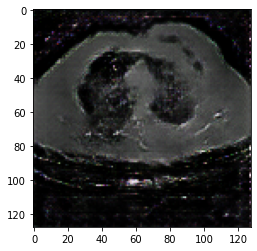

In [15]:
plt.imshow(X[49])

In [61]:
latent_dim = 100
discriminator = define_discriminator()
gan_model = define_gan(model, discriminator)
print(X.shape)
train(model, discriminator, gan_model,dataset , latent_dim, n_epochs=1)

(50, 128, 128, 3)
Epoch>1, Batch 1/64, d1=0.620, d2=1.003 g=0.552
Epoch>1, Batch 2/64, d1=0.545, d2=0.900 g=0.588
Epoch>1, Batch 3/64, d1=0.590, d2=0.828 g=0.621
Epoch>1, Batch 4/64, d1=0.617, d2=0.794 g=0.643
Epoch>1, Batch 5/64, d1=0.636, d2=0.768 g=0.665
Epoch>1, Batch 6/64, d1=0.649, d2=0.757 g=0.673
Epoch>1, Batch 7/64, d1=0.669, d2=0.746 g=0.674
Epoch>1, Batch 8/64, d1=0.668, d2=0.739 g=0.675
Epoch>1, Batch 9/64, d1=0.671, d2=0.738 g=0.672
Epoch>1, Batch 10/64, d1=0.668, d2=0.738 g=0.669
Epoch>1, Batch 11/64, d1=0.669, d2=0.740 g=0.672
Epoch>1, Batch 12/64, d1=0.666, d2=0.743 g=0.670
Epoch>1, Batch 13/64, d1=0.662, d2=0.745 g=0.669
Epoch>1, Batch 14/64, d1=0.656, d2=0.747 g=0.673
Epoch>1, Batch 15/64, d1=0.655, d2=0.743 g=0.678
Epoch>1, Batch 16/64, d1=0.662, d2=0.746 g=0.677
Epoch>1, Batch 17/64, d1=0.661, d2=0.745 g=0.676
Epoch>1, Batch 18/64, d1=0.664, d2=0.741 g=0.675
Epoch>1, Batch 19/64, d1=0.670, d2=0.738 g=0.678
Epoch>1, Batch 20/64, d1=0.672, d2=0.731 g=0.680
Epoch>1, Ba